In [71]:
import numpy as np
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
sleep_study_tbl = Table.read_table('sleep_study.csv').select('On avgerage how many hours of sleep do you get per night?', 'How satisfied are you with your academic performance this year? (1 being the worst, 5 being the best)', 'How many hours per week do you study?')
sleep_study_tbl = sleep_study_tbl.relabel('On avgerage how many hours of sleep do you get per night?', 'sleep per night (hrs)')
sleep_study_tbl = sleep_study_tbl.relabel('How satisfied are you with your academic performance this year? (1 being the worst, 5 being the best)', 'academic satisfaction')
sleep_study_tbl = sleep_study_tbl.relabel('How many hours per week do you study?', 'study per week (hrs)')
sleep_study_tbl


sleep per night (hrs),academic satisfaction,study per week (hrs)
4-6,3,6-8
6-8,3,More than 8
4-6,3,4-6
4-6,3,More than 8
6-8,5,4-6
4-6,3,6-8
6-8,3,4-6
6-8,4,Less than 4
More than 8,4,More than 8
4-6,3,Less than 4


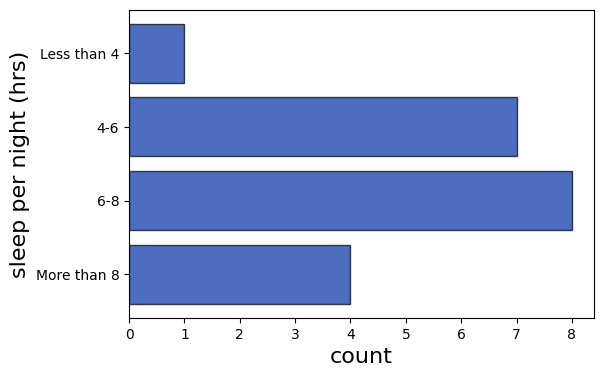

In [73]:
sleep_study_tbl.group('sleep per night (hrs)').with_column('min_hour', [4,6,0,8]).sort('min_hour').drop('min_hour').barh('sleep per night (hrs)')


In [74]:
def calc_ab_test_stat(cat_col, academic_sat_col):
    table = Table().with_columns('sleep_per_night', cat_col,
                                 'academic satisfaction', academic_sat_col)
    table = table.group('sleep_per_night', np.mean).sort('sleep_per_night')
    avg_col = table.column('academic satisfaction mean')
    difference_stat = avg_col[0] - avg_col[1]
    return difference_stat



In [75]:
def a_b_shuffle(table):
    cat_col = table.column('sleep per night (hrs)')
    np.random.shuffle(cat_col)
    table = table.with_columns('sleep per night (hrs)', cat_col)
    return table


In [76]:
# Transforms sleep categories into a binary column (above/below 6 hours)
binary_catergories = sleep_study_tbl.select('sleep per night (hrs)', 'academic satisfaction').apply(
    lambda x: 'less than 6' if x[0].startswith('Less') or x[0].startswith('4') else 'greater than 6')

a_b_slp_tbl = sleep_study_tbl.select('academic satisfaction').with_column('sleep per night (hrs)', binary_catergories)

obs_stat = calc_ab_test_stat(a_b_slp_tbl.column('sleep per night (hrs)'),a_b_slp_tbl.column('academic satisfaction'))


In [77]:

a_b_statistic_arr = []
for i in range(100000):
    shuffled_table = a_b_shuffle(a_b_slp_tbl)
    a_b_statistic_arr.append(calc_ab_test_stat(shuffled_table.column('sleep per night (hrs)'), shuffled_table.column('academic satisfaction')))

a_b_statistic_arr = np.array(a_b_statistic_arr)


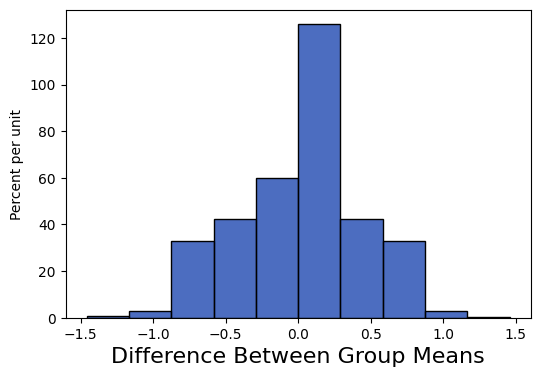

In [78]:
Table().with_column('Difference Between Group Means', a_b_statistic_arr).hist(bins=10)

In [79]:
abv_obsrvd = a_b_statistic_arr > obs_stat
p_val = np.count_nonzero(abv_obsrvd)/ len(abv_obsrvd)
p_val

9.0000000000000006e-05

In [80]:
def bootstrapping_acd_sat(table):
    resampled_acd_sat = table.sample().column('academic satisfaction')
    academic_sat_mean = np.mean(resampled_acd_sat)
    return academic_sat_mean

In [81]:
bootstrapping_stat_arr = []
for i in range(100000):
    bootstrapping_acd_sat(sleep_study_tbl)
    bootstrapping_stat_arr.append(bootstrapping_acd_sat(sleep_study_tbl))

bootstrapping_stat_arr = np.array(bootstrapping_stat_arr)
bootstrapping_stat_arr

array([ 3.6 ,  3.7 ,  4.  , ...,  3.55,  3.95,  3.35])

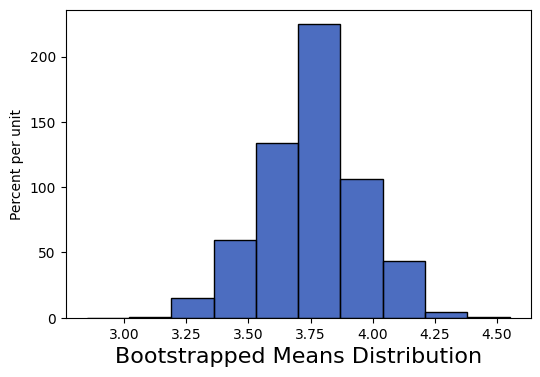

In [82]:
Table().with_column('Bootstrapped Means Distribution', bootstrapping_stat_arr).hist(bins=10)

In [83]:
lower_bound = percentile(2.5, bootstrapping_stat_arr)
upper_bound = percentile(97.5, bootstrapping_stat_arr)
print(f'.05 Confidence Interval: [{lower_bound}, {upper_bound}]')


.05 Confidence Interval: [3.35, 4.15]
